# COMPAS Racial Bias Analysis

## Import Packages

In [1]:
import numpy as np
import matplotlib as matplt
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import norm
from scipy import stats
from sklearn import (
    linear_model, metrics, pipeline, preprocessing, model_selection
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from datetime import datetime
from time import time
import random
import sys
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import RepeatedKFold
# from sklearn.linear_model import Lasso
import warnings
warnings.filterwarnings('ignore')

## Prepare Data

In [2]:
dataURL = 'https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years-violent.csv'
raw_data = pd.read_csv(dataURL)
print(raw_data.shape)
raw_data.columns
# raw_data.head()

(4743, 54)


Index(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid',
       'is_violent_recid', 'vr_case_number', 'vr_charge_degree',
       'vr_offense_date', 'vr_charge_desc', 'type_of_assessment',
       'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1',
       'start', 'end', 'event', 'two_year_recid', 'two_year_recid.1'],
      dtype='object')

### Data Description
* age: Age of the defendant. It is numeric.
* age_cat: Category of Age. It can be < 25, 25-45, >45.
* sex: Sex of the defendant. It is either 'Male' or 'Female'
* race: Race of the defendant. It can be 'African-American', 'Caucasian', 'Hispanic', 'Asian', or 'Other'.
* juv_fel_count: The number of prior juvenile felonie of the defendant.
* juv_misd_count: The number of prior juvenile misdemeanors of the defendant.
* juv_other_count: The number of juvenile convictions that are neither a felony nor a misdemeanor
* c_charge_degree: Degree of the crime. It is either M (Misdemeanor), F (Felony), or O (not causing jail time).
* priors_count: Count of prior crimes committed by the defendant. It is numeric.
* days_b_screening_arrest: Days between the arrest and COMPAS screening.
* decile_score: The COMPAS score predicted by the system. It is between 0-10.
* score_text: Category of decile score. It can be Low (1-4), Medium (5-7), and High (8-10).
* is_recid: A variable to indicate if recidivism was done by the defendant. It can be 0, 1, -1.
* two_year_recid: A variable to indicate if recidivism was done by the defendant within two years.
* c_jail_in: Time when the defendant was jailed.
* c_jail_out: Time when the defendant was released from the jail.

In [3]:
# raw_data.isna().sum()

### Data Cleaning
However not all of the rows are useable for the first round of analysis.

There are a number of reasons remove rows because of missing data:
* If the charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested, we assume that because of data quality reasons, that we do not have the right offense.
* We coded the recidivist flag -- `is_recid` -- to be -1 if we could not find a compas case at all.
* In a similar vein, ordinary traffic offenses -- those with a `c_charge_degree` of 'O' -- will not result in Jail time are removed (only two of them).
* We filtered the underlying data from Broward county to include only those rows representing people who had either recidivated in two years, or had at least two years outside of a correctional facility.

In [4]:
compas_df = raw_data.loc[
    (raw_data['days_b_screening_arrest'] <= 30) &
    (raw_data['days_b_screening_arrest'] >= -30) &
    (raw_data['is_recid'] != -1) &
    (raw_data['c_charge_degree'] != "O") &
    (raw_data['score_text'] != "N/A")
]
len(compas_df)

4020

## COMPAS Score and Recidivism


We visualize the data to see how scores and race correlate to each other

### Exploratory Analysis

#### Score and Race

In [5]:
compas_df['race'].value_counts()

African-American    1918
Caucasian           1459
Hispanic             355
Other                255
Asian                 26
Native American        7
Name: race, dtype: int64

<AxesSubplot:title={'center':'Score Text by Race'}, xlabel='Race', ylabel='Score Text'>

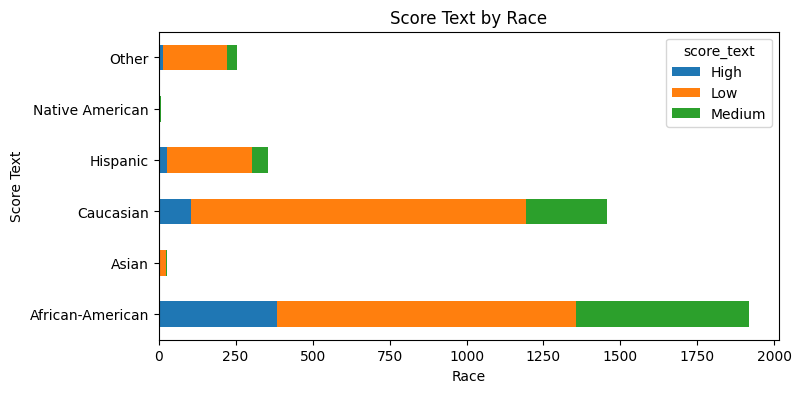

In [6]:
score_text_by_race = compas_df.groupby(['race','score_text'], sort = True)['id'].size()
score_text_by_race.unstack().plot(
    kind = "barh", 
    title = "Score Text by Race",
    ylabel = "Score Text",
    xlabel = "Race",
    figsize = (8,4),
    stacked = True
)

African American group has the highest number of High Scores individuals. However, they are also the biggest group, so we need to consider the proportions of score text in each Race group. 

In [7]:
#calculate the total and proportions of score texts in each race group
score_text_by_race_prop= compas_df.groupby(['race', 'score_text']).agg({'score_text': 'count'})
score_text_by_race_prop['prop'] = score_text_by_race_prop.groupby(level = 0).apply(lambda x:100 * x / float(x.sum()))
score_text_by_race_prop

score_text       prop
race             score_text                       
African-American High               386  20.125130
                 Low                969  50.521376
                 Medium             563  29.353493
Asian            High                 2   7.692308
                 Low                 22  84.615385
                 Medium               2   7.692308
Caucasian        High               105   7.216495
                 Low               1087  74.707904
                 Medium             263  18.075601
Hispanic         High                26   7.323944
                 Low                277  78.028169
                 Medium              52  14.647887
Native American  High                 2  28.571429
                 Low                  3  42.857143
                 Medium               2  28.571429
Other            High                15   5.905512
                 Low                208  81.889764
                 Medium              31  12.204724

26,6% of African-American defendants are classified with High Scores compared to 10.6% of Caucasian group

#### Distribution of decile scores
There is a clear downtrend in Decile Score for Caucasian and Hispanic; however, no downtrend for African-American.

<AxesSubplot:title={'center':'Decile Score Histogram by Race (%)'}, xlabel='Race', ylabel='%'>

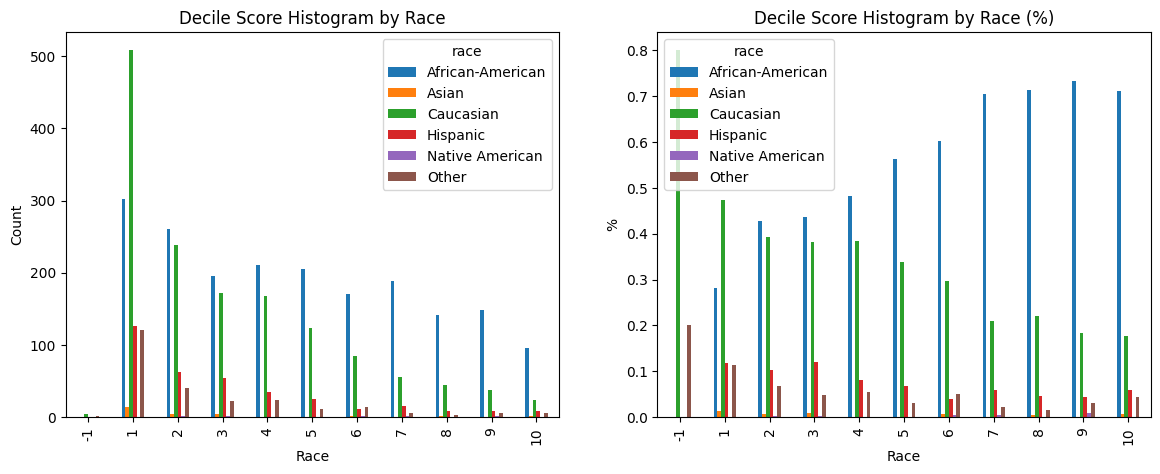

In [8]:
fig, axs = plt.subplots(1,2, figsize=(14, 5))
# Decile Score by race
compas_df.groupby('decile_score')['race'].value_counts(normalize = False).unstack().plot(
    kind = "bar",
    title = "Decile Score Histogram by Race",
    ylabel = "Count",
    xlabel = "Race",
    ax=axs[0])


compas_df.groupby('decile_score')['race'].value_counts(normalize = True).unstack().plot(
    kind = "bar",
    title = "Decile Score Histogram by Race (%)",
    ylabel = "%",
    xlabel = "Race",
    ax=axs[1])

In [9]:
# sns.countplot(
#     data = compas_df,
#     x = 'decile_score',
#     hue = 'race',
#     palette = ["#F97306","#0343compas_df","#00FF00"]
# )
# plt.title('Distribution of Decile Scores by Race')
# plt.xlabel('Decile Score')
# plt.ylabel('Count')

In [10]:
compas_df.groupby('race')['decile_score'].describe()

,count,mean,std,min,25%,50%,75%,max
race,,,,,,,,
African-American,1918.0,4.714807,2.795312,1.0,2.0,4.0,7.0,10.0
Asian,26.0,2.461538,2.403843,1.0,1.0,1.0,3.0,10.0
Caucasian,1459.0,3.156957,2.374282,-1.0,1.0,2.0,5.0,10.0
Hispanic,355.0,3.064789,2.374244,1.0,1.0,2.0,4.0,10.0
Native American,7.0,5.428571,3.101459,2.0,2.5,6.0,8.0,9.0
Other,255.0,2.678431,2.339015,-1.0,1.0,2.0,4.0,10.0
